In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Import the first CSV file
feature_df = pd.read_csv('ufc_aug.csv')

#prepare data for training

# Drop the columns
columns_to_drop = ['p1_fighter', 'p2_fighter', 'event_date'] #method
feature_df = feature_df.drop(columns=columns_to_drop)
cols_to_drop = [col for col in feature_df.columns if col.startswith('method_')]
feature_df.drop(columns=cols_to_drop, inplace=True)

# Clean all column names
def clean_column_name(col):
    return col.lower().replace(' ', '_').replace('.', '').replace('-', '_')

# Apply to all columns
feature_df.columns = [clean_column_name(col) for col in feature_df.columns]

# Identify all categorical columns
categorical_cols = ['p1_stance', 'p2_stance']

# One-hot encode all categorical variables
feature_df = pd.get_dummies(feature_df, columns=categorical_cols)

feature_df = feature_df.sample(frac=1, random_state=42).reset_index(drop=True)

# encode the referee using frequency
ref_counts = feature_df['referee'].value_counts()
feature_df['referee_freq'] = feature_df['referee'].map(ref_counts)
feature_df.drop(columns=['referee'], inplace=True)

# Target setup
X = feature_df.drop(columns=['winner'])
y = feature_df['winner']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Identify numeric columns for imputation
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Impute missing values with median
num_imputer = SimpleImputer(strategy='median')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

# XGBoost model training with evaluation tracking
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Define evaluation sets for learning curves
evalset = [(X_train, y_train), (X_test, y_test)]

# Fit model with evaluation tracking
xgb_model.fit(X_train, y_train, eval_set=evalset, verbose=False)

# Predictions and evaluation
xgb_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, xgb_pred)
report = classification_report(y_test, xgb_pred)

print("XGBoost Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance.to_string())

# Save the model
xgb_model.save_model('xgb_model_good.json')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:10:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Performance:
Accuracy: 0.6605
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      1635
           1       0.66      0.67      0.66      1649

    accuracy                           0.66      3284
   macro avg       0.66      0.66      0.66      3284
weighted avg       0.66      0.66      0.66      3284


Feature Importances:
                            Feature  Importance
28                        slpm_diff    0.035585
30                        sapm_diff    0.022499
34                       tddef_diff    0.016555
10                       p1_sub_avg    0.013946
21                       p2_sub_avg    0.012859
27                         age_diff    0.012651
29                      stracc_diff    0.012315
52          p1_age_adjusted_str_acc    0.012174
53          p2_age_adjusted_str_acc    0.011288
31                      strdef_diff    0.011115
32                       tdavg_diff    0.010536
19      

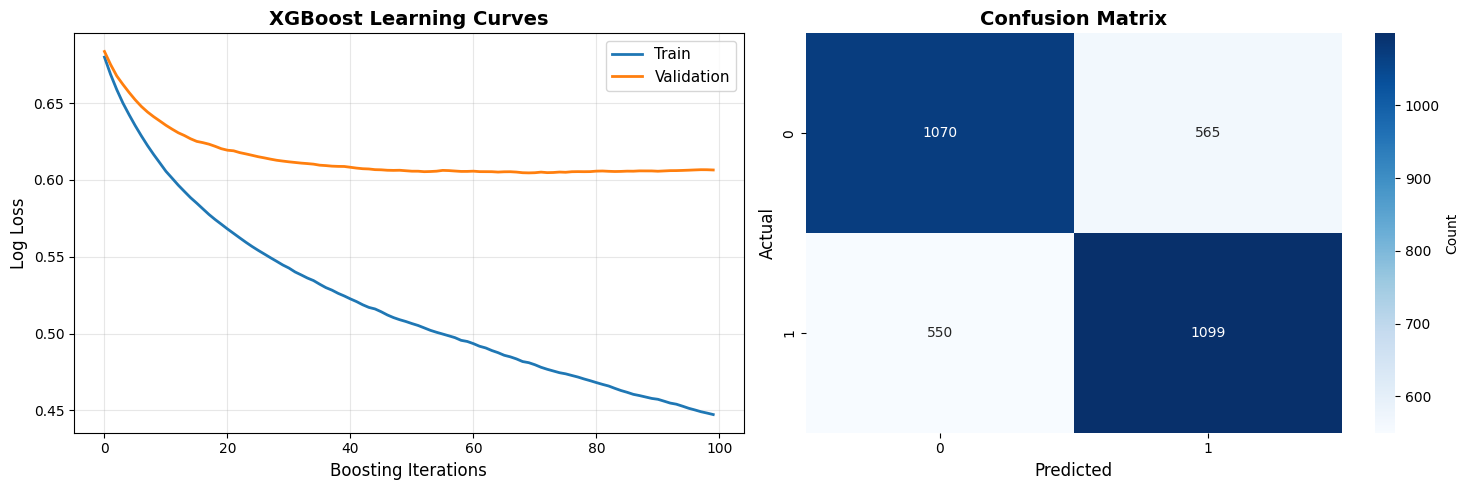

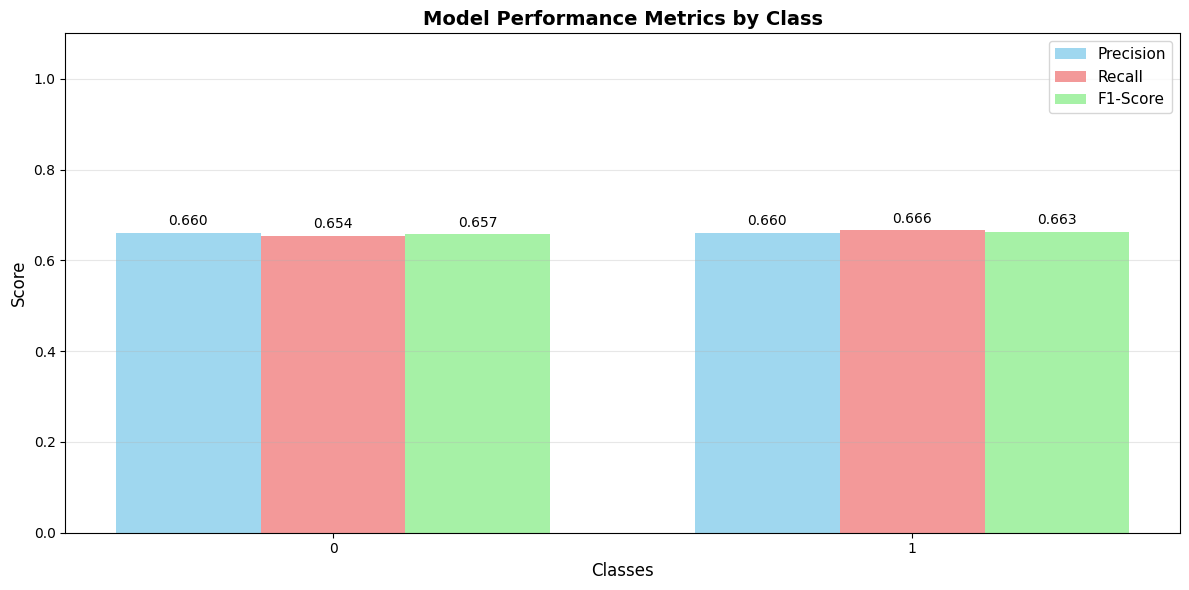

In [2]:
# Performance Visualization - Learning Curves and Confusion Matrix
results = xgb_model.evals_result()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Learning curves
ax1.plot(results['validation_0']['logloss'], label='Train', linewidth=2)
ax1.plot(results['validation_1']['logloss'], label='Validation', linewidth=2)
ax1.set_title('XGBoost Learning Curves', fontsize=14, fontweight='bold')
ax1.set_xlabel('Boosting Iterations', fontsize=12)
ax1.set_ylabel('Log Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Confusion Matrix
y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, 
            cbar_kws={'label': 'Count'})
ax2.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

# Additional Performance Metrics by Class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
classes = xgb_model.classes_

# Create performance comparison plot
metrics_df = pd.DataFrame({
    'Class': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8, color='skyblue')
bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8, color='lightcoral')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8, color='lightgreen')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics by Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.show()


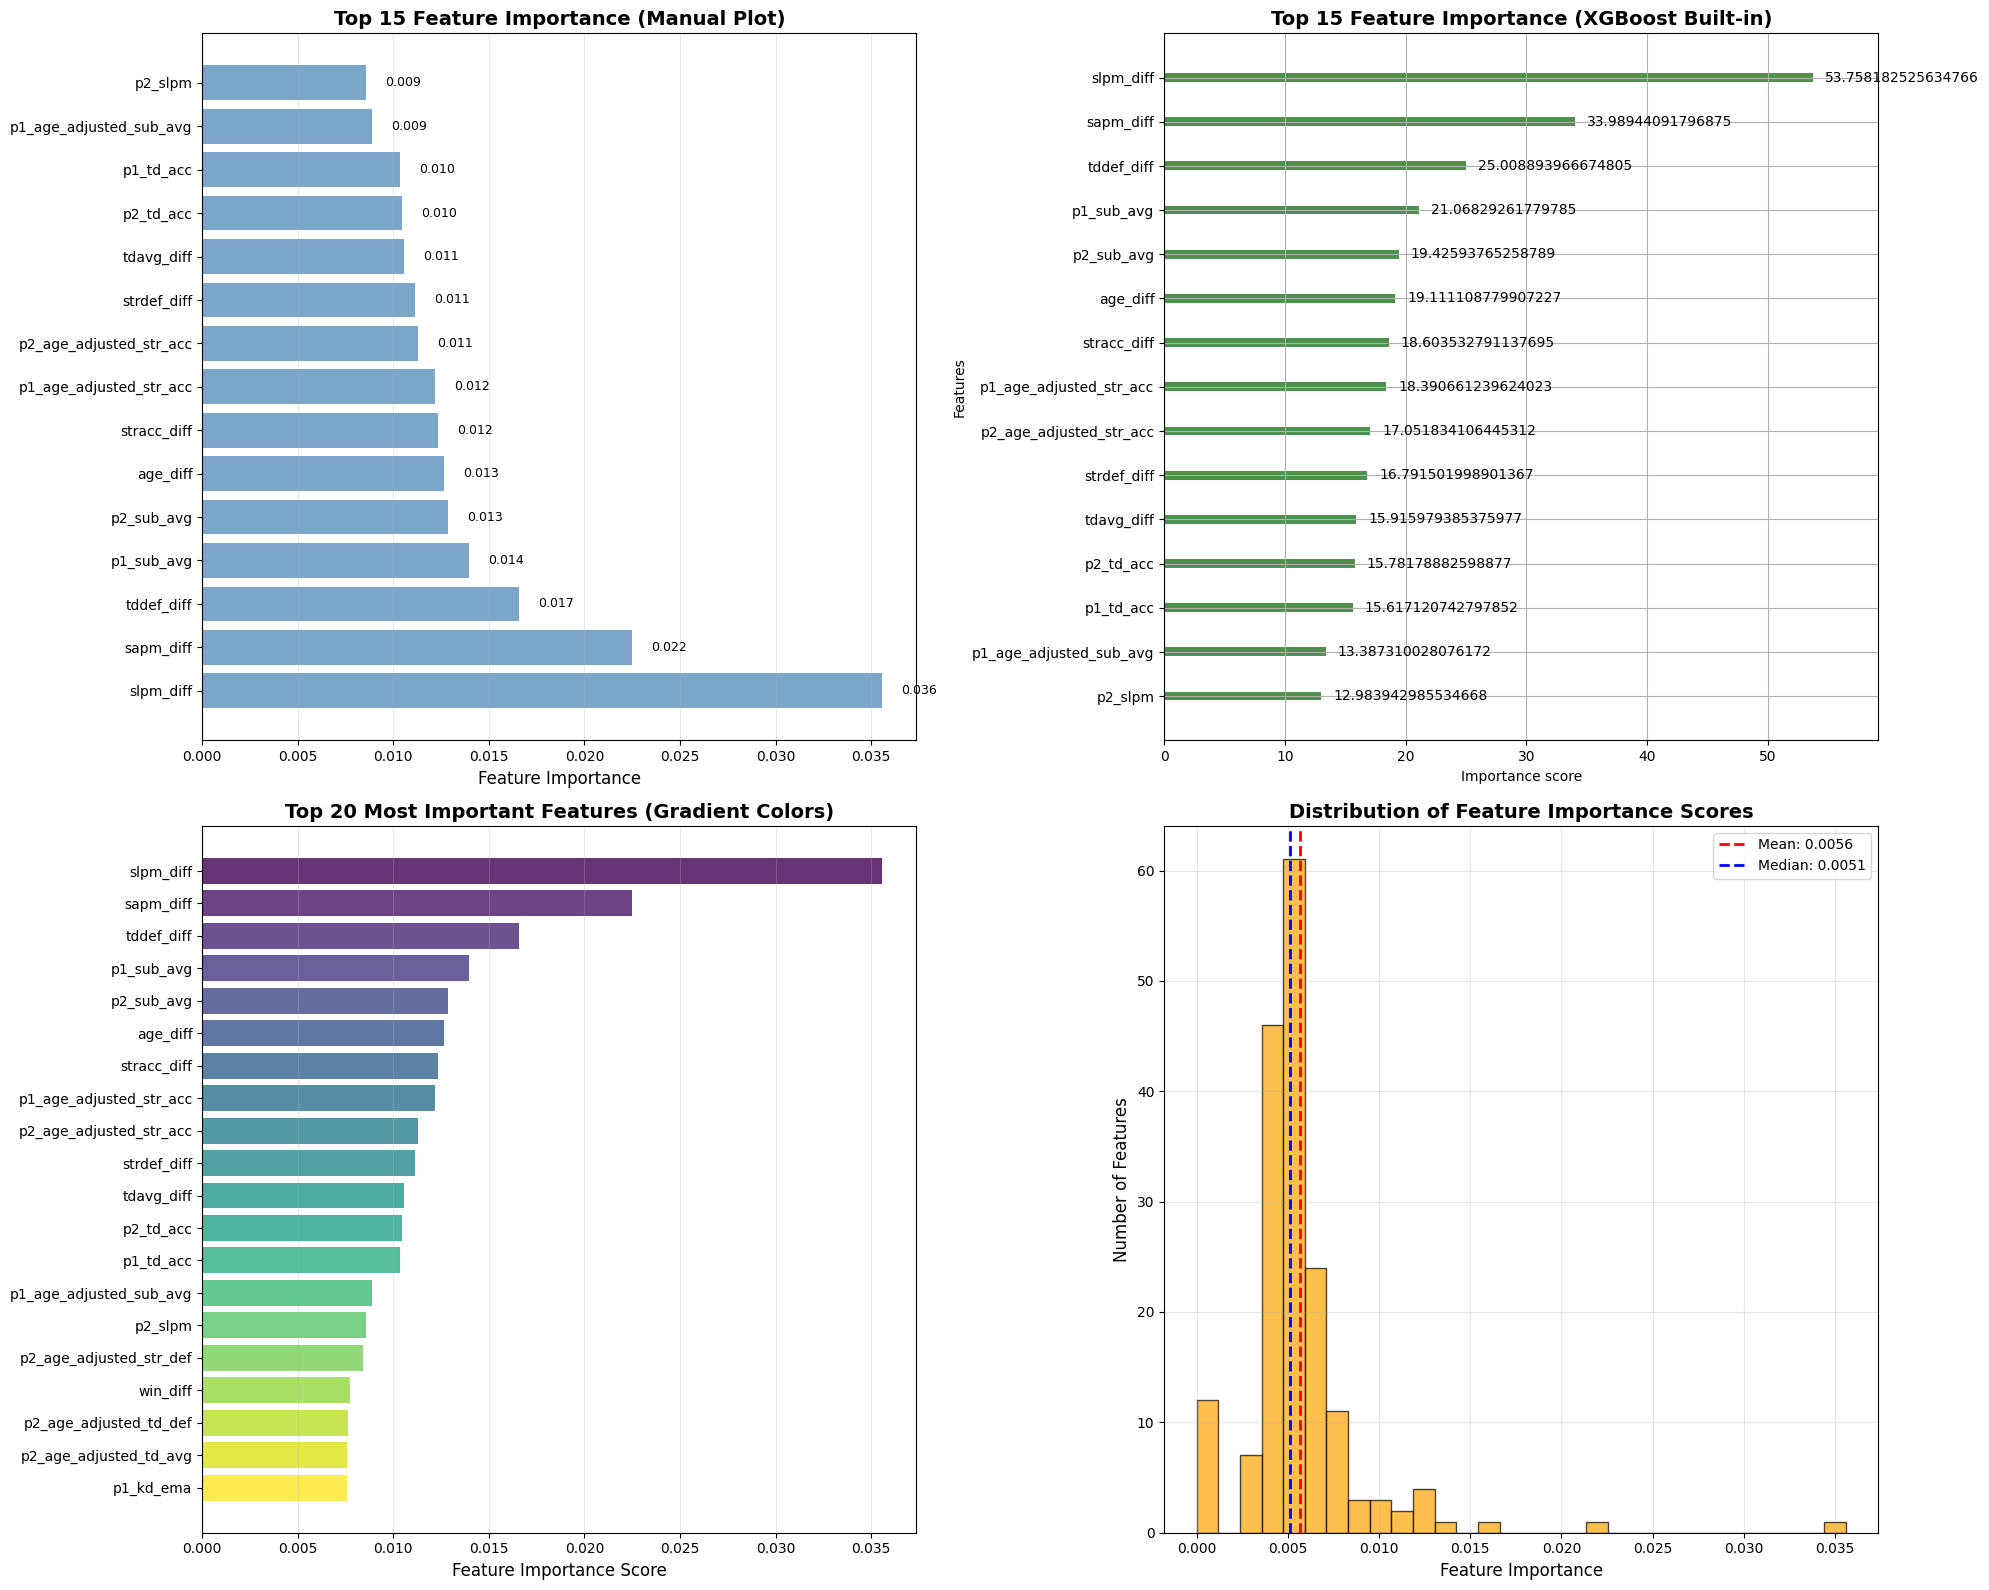

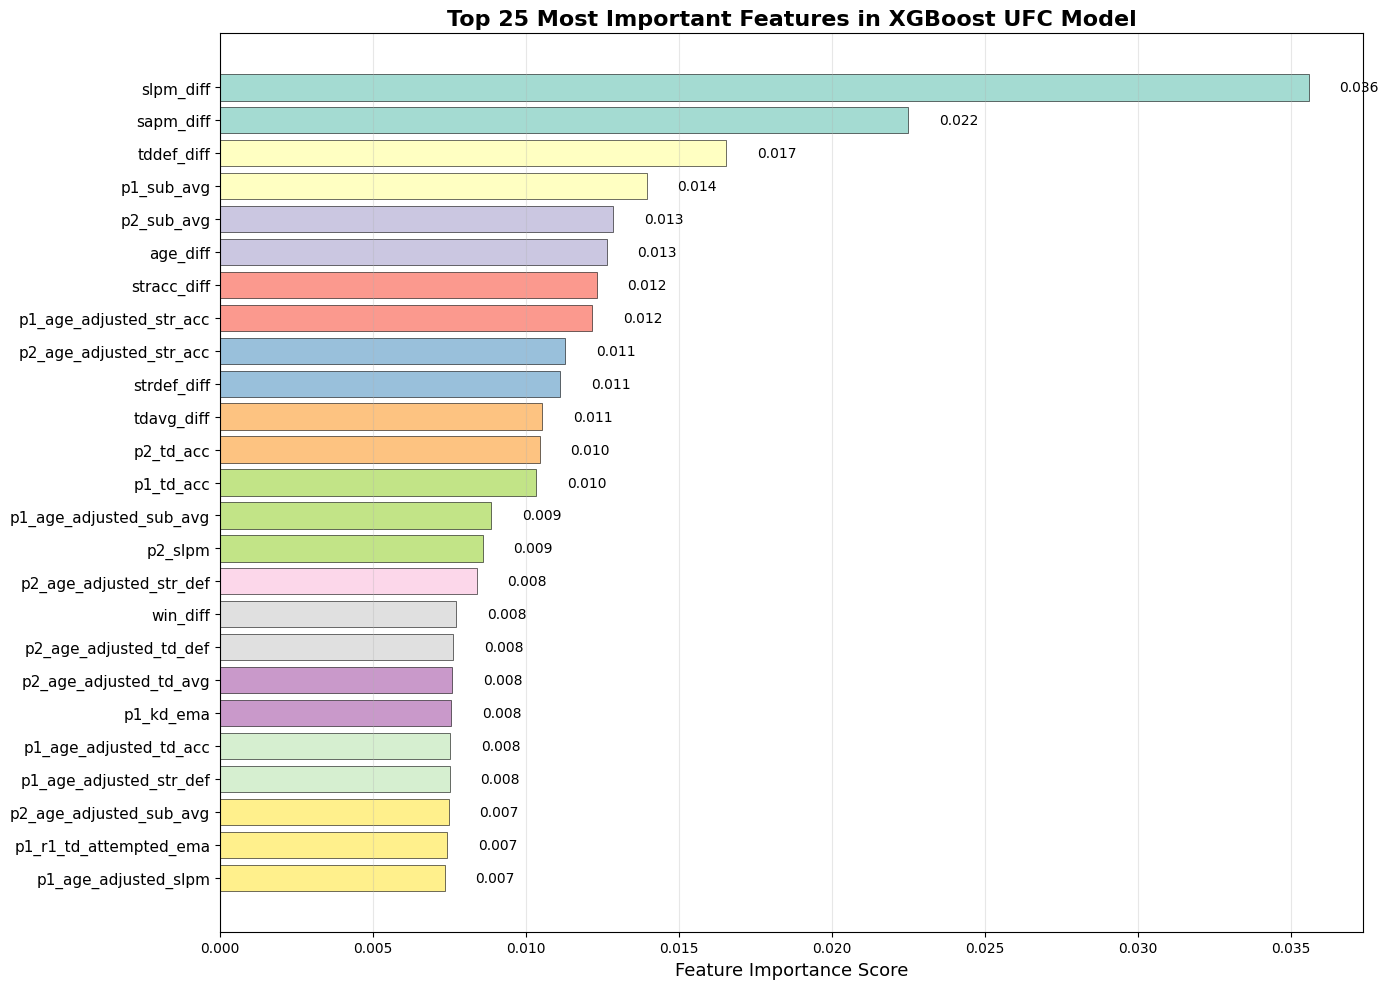


Feature Importance Summary:
Total features: 177
Top feature: slpm_diff (importance: 0.0356)
Mean importance: 0.0056
Median importance: 0.0051
Features with importance > 0.01: 13


In [3]:
# Feature Importance Visualization
from xgboost import plot_importance

# Create comprehensive feature importance plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Top 15 features - Manual matplotlib plot
feature_importance_top15 = feature_importance.head(15)
bars1 = ax1.barh(range(len(feature_importance_top15)), feature_importance_top15['Importance'], 
                 color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(feature_importance_top15)))
ax1.set_yticklabels(feature_importance_top15['Feature'], fontsize=10)
ax1.set_xlabel('Feature Importance', fontsize=12)
ax1.set_title('Top 15 Feature Importance (Manual Plot)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

# Plot 2: Built-in XGBoost plot_importance function
plot_importance(xgb_model, ax=ax2, max_num_features=15, importance_type='gain', 
                color='darkgreen', alpha=0.7)
ax2.set_title('Top 15 Feature Importance (XGBoost Built-in)', fontsize=14, fontweight='bold')

# Plot 3: Top 20 features with different styling
top_20_features = feature_importance.head(20)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_20_features)))
bars3 = ax3.barh(range(len(top_20_features)), top_20_features['Importance'], 
                 color=colors, alpha=0.8)
ax3.set_yticks(range(len(top_20_features)))
ax3.set_yticklabels(top_20_features['Feature'], fontsize=10)
ax3.set_xlabel('Feature Importance Score', fontsize=12)
ax3.set_title('Top 20 Most Important Features (Gradient Colors)', fontsize=14, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Feature importance distribution
ax4.hist(feature_importance['Importance'], bins=30, alpha=0.7, color='orange', edgecolor='black')
ax4.set_xlabel('Feature Importance', fontsize=12)
ax4.set_ylabel('Number of Features', fontsize=12)
ax4.set_title('Distribution of Feature Importance Scores', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add statistics to the histogram
mean_importance = feature_importance['Importance'].mean()
median_importance = feature_importance['Importance'].median()
ax4.axvline(mean_importance, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_importance:.4f}')
ax4.axvline(median_importance, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_importance:.4f}')
ax4.legend()

plt.tight_layout()
plt.show()

# Additional detailed single plot for top features
plt.figure(figsize=(14, 10))
top_25_features = feature_importance.head(25)
colors = plt.cm.Set3(np.linspace(0, 1, len(top_25_features)))
bars = plt.barh(range(len(top_25_features)), top_25_features['Importance'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.yticks(range(len(top_25_features)), top_25_features['Feature'], fontsize=11)
plt.xlabel('Feature Importance Score', fontsize=13)
plt.title('Top 25 Most Important Features in XGBoost UFC Model', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nFeature Importance Summary:")
print(f"Total features: {len(feature_importance)}")
print(f"Top feature: {feature_importance.iloc[0]['Feature']} (importance: {feature_importance.iloc[0]['Importance']:.4f})")
print(f"Mean importance: {feature_importance['Importance'].mean():.4f}")
print(f"Median importance: {feature_importance['Importance'].median():.4f}")
print(f"Features with importance > 0.01: {(feature_importance['Importance'] > 0.01).sum()}")


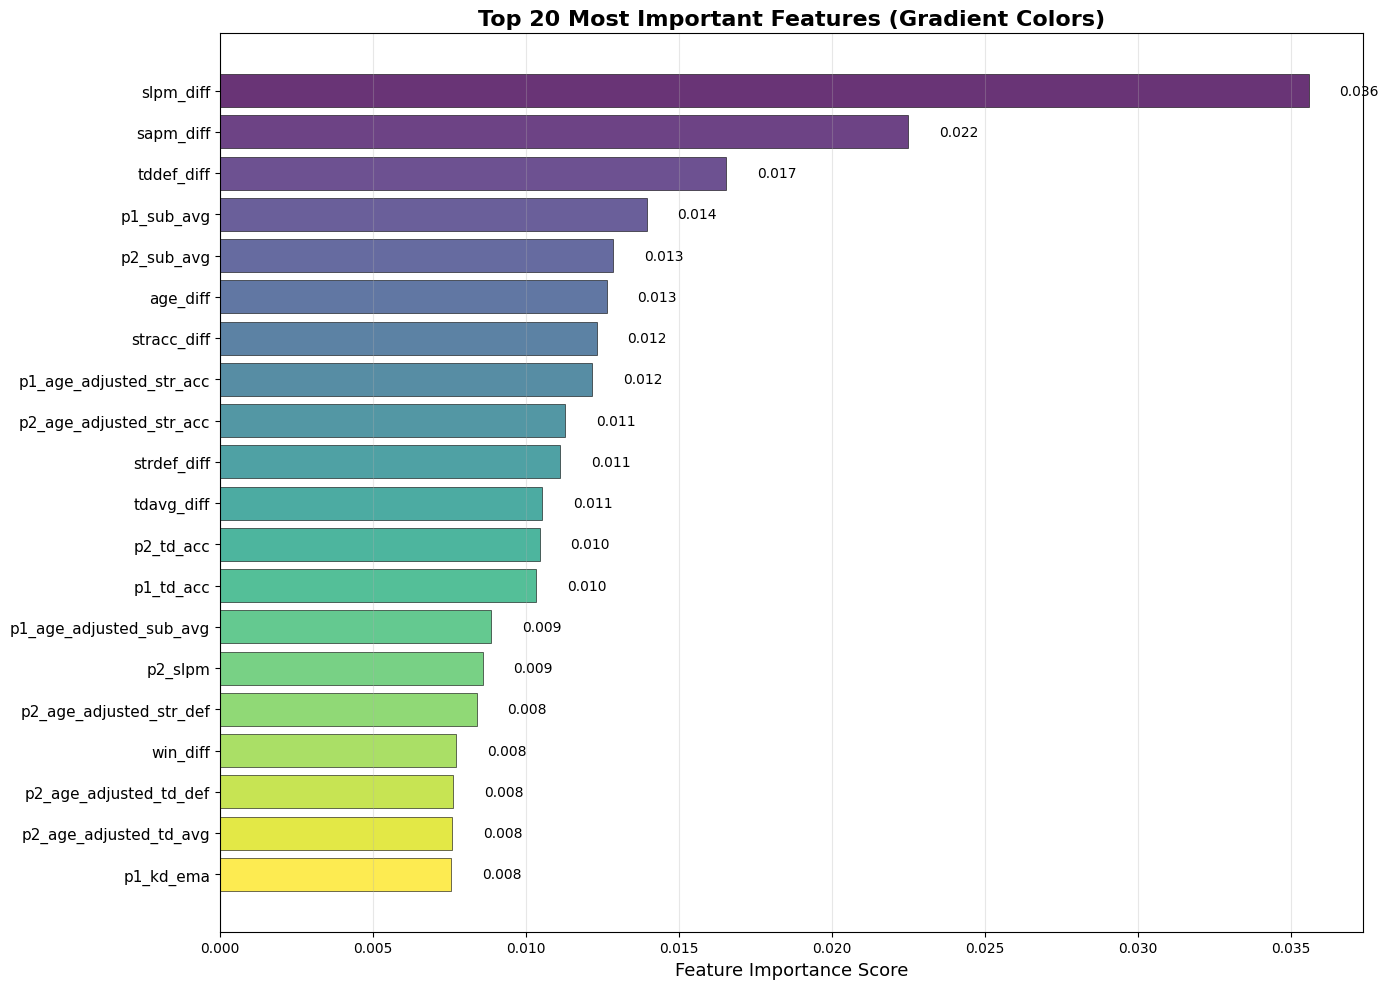

Graph exported as 'top_20_feature_importance_gradient.png' and 'top_20_feature_importance_gradient.pdf'


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Create the Top 20 features plot with gradient colors
plt.figure(figsize=(14, 10))
top_20_features = feature_importance.head(20)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_20_features)))
bars = plt.barh(range(len(top_20_features)), top_20_features['Importance'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.yticks(range(len(top_20_features)), top_20_features['Feature'], fontsize=11)
plt.xlabel('Feature Importance Score', fontsize=13)
plt.title('Top 20 Most Important Features (Gradient Colors)', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()

# Export the plot
plt.savefig('top_20_feature_importance_gradient.png', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white', 
            edgecolor='none')

# Optionally save as PDF as well
plt.savefig('top_20_feature_importance_gradient.pdf', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white', 
            edgecolor='none')

plt.show()

print("Graph exported as 'top_20_feature_importance_gradient.png' and 'top_20_feature_importance_gradient.pdf'")


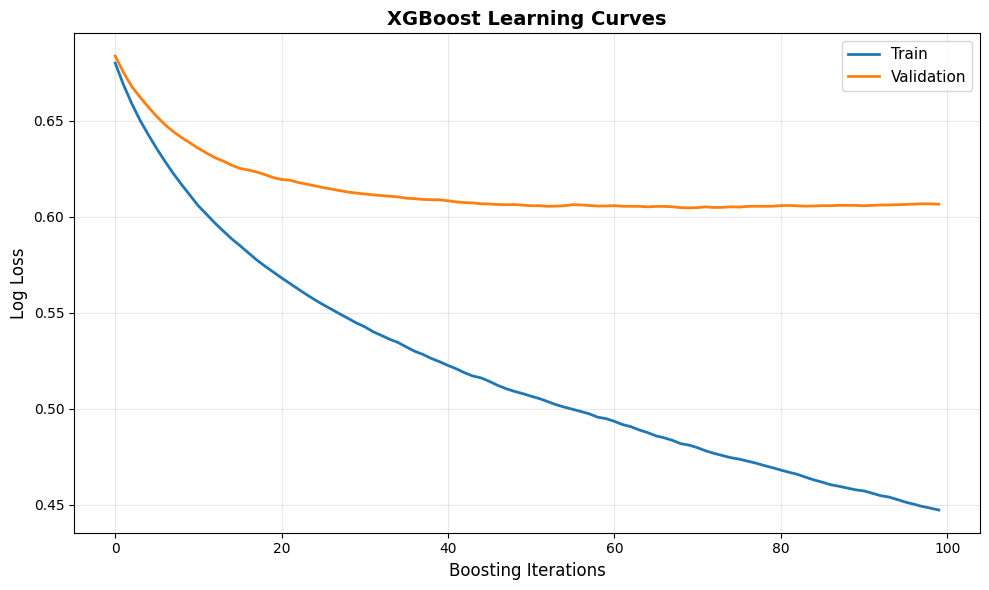

Learning curve exported as 'learning_curve.png'


In [5]:
# Generate and export the learning curve graph separately
results = xgb_model.evals_result()

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['logloss'], label='Train', linewidth=2)
plt.plot(results['validation_1']['logloss'], label='Validation', linewidth=2)
plt.title('XGBoost Learning Curves', fontsize=14, fontweight='bold')
plt.xlabel('Boosting Iterations', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Export the learning curve plot
plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("Learning curve exported as 'learning_curve.png'")


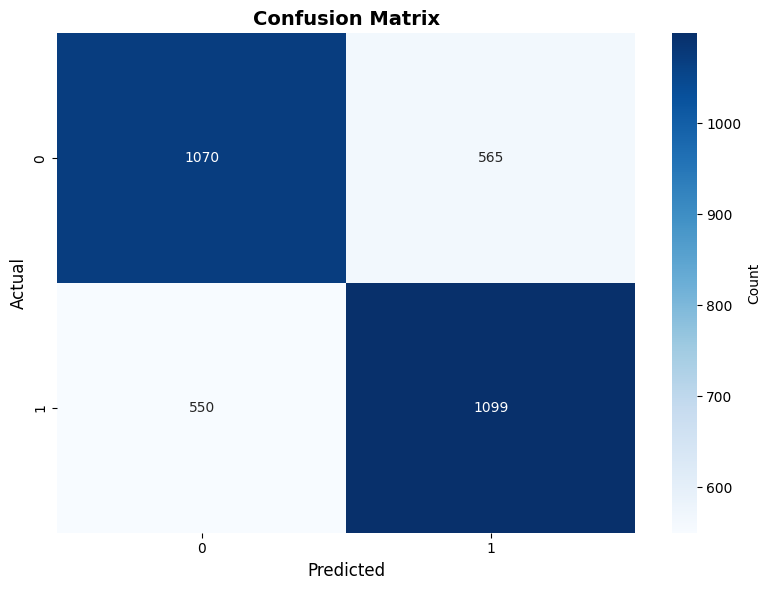

Confusion matrix exported as 'confusion_matrix.png'


In [6]:
# Generate and export the confusion matrix separately
y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()

# Export the confusion matrix plot
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("Confusion matrix exported as 'confusion_matrix.png'")
